# Analysis of DSLWP-B 2018-08-12 SSDV transmission #3

This notebook analyzes SSDV transmissions made by DSLWP-B from the Moon.

In [1]:
%matplotlib inline

import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

We load a file containing the relevant GMSK transmission. The recording was done at the Dwingeloo radiotelescope and can be obtained [here](https://charon.camras.nl/public/dslwp-b/DSLWP-B_PI9CAM_2018-08-12T06_58_02_436.4MHz_40ksps_complex.raw). Remember to edit the path below to point to the correct file.

In [2]:
x = np.fromfile('/home/daniel/Descargas/DSLWP-B_PI9CAM_2018-08-12T08_32_25_436.4MHz_40ksps_complex.raw', dtype='complex64')

The 250bps GMSK signal is converted down to baseband and lowpass filtered to 800Hz.

In [3]:
fs = 40e3
f = 1400
x = x * np.exp(-1j*2*np.pi*np.arange(x.size)*f/fs).astype('complex64')

h = scipy.signal.firwin(1000, 0.01).astype('float32')
x = scipy.signal.lfilter(h, 1, x).astype('complex64')

Perform arctangent FSK demodulation.

In [4]:
s = np.diff(np.angle(x).astype('float32'))

Correct for phase wrapping.

In [5]:
s[s > np.pi] -= 2*np.pi
s[s < -np.pi] += 2*np.pi

In [6]:
#s.tofile('/home/daniel/s.f32')

In [7]:
#s = np.fromfile('/home/daniel/s.f32', dtype='float32')

We extract the soft bits by guessing the correct clock phase and decimating. No pulse shaping matched filtering has been done, and tracking of the clock frequency doesn't seem necessary either. The separation between the bits 1 and 0 is good enough for demodulation without bit errors.

Note that we correct for the clock drift and for frequency offset and drift. This simple open loop clock recovery is enough to get good separation between the bits, even across different GMSK transmissions.

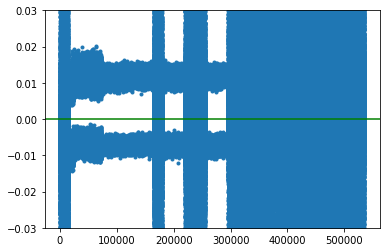

In [8]:
phase = 110
softbits = s[np.int32(np.arange(phase,s.size,160 - 0.0006))]
softbits = softbits + 1.7e-8 * np.arange(softbits.size) - 0.0035 # correction for frequency offset and drift
plt.plot(softbits,'.')
plt.axhline(y = 0, color='green')
plt.ylim([-0.03,0.03]);

Now we decompose the plot above in chunks to see some more details. The first plot shows a frequency jump that we will show in more detail later. It is also interesting that some phase/clock noise gets reduced after bit 70000.

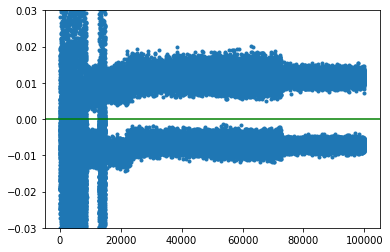

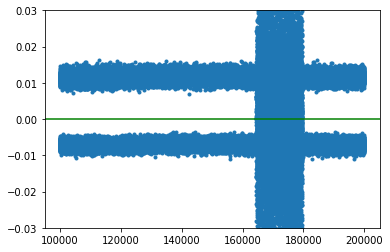

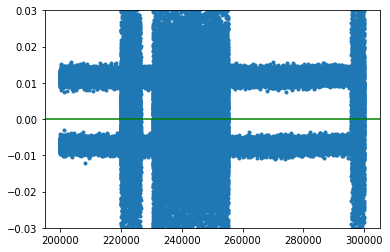

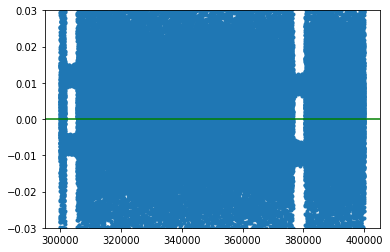

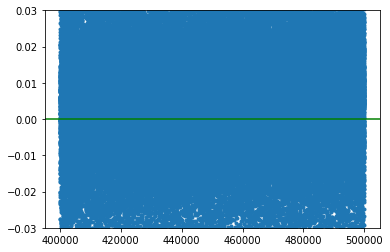

In [9]:
starts = np.arange(0,softbits.size,100000)
ranges = zip(starts[:-1], starts[1:])
for r in ranges:
    plt.figure()
    plt.plot(np.arange(r[0],r[1]), softbits[r[0]:r[1]], '.')
    plt.axhline(y = 0, color='green')
    plt.ylim([-0.03,0.03]);

Soft bits are now converted to hard bits.

In [10]:
bits = (softbits > 0)*1

Now we undo GMSK precoding, since we want to export the OQPSK bits. This part is tricky and use the knowledge of the ASM to correct for phase ambiguities.

As a first step, since the GMSK bits are differential phase, a cumulative sum of them gives phase, which can be converted to the QPSK constellation.

In [11]:
decbits = np.cumsum(np.int32(2*bits-1))%4
decbits[::2] = (decbits[::2] == 1)*1
decbits[1::2] = (decbits[1::2] == 0)*1

However we need to consider another branch in which I and Q are swapped, so the sign of one of them is inverted (consider swapping I and Q versus multiplying by 1j).

In [12]:
decbits_inv = decbits.copy()
decbits_inv[::2] ^= 1

We correlate both branches against the uncoded ASM. Note the correlation can happen on either branch and have either sign.

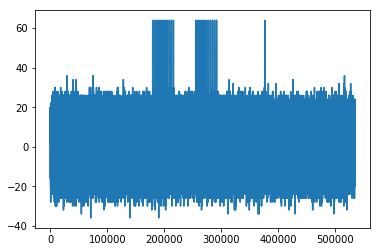

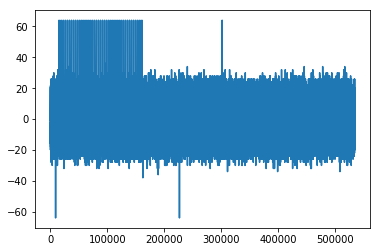

In [13]:
asm = np.unpackbits(np.array([0x03,0x47,0x76,0xC7,0x27,0x28,0x95,0xB0], dtype='uint8'))
asm_straight_corr = scipy.signal.correlate(2*decbits-1, 2*asm.astype('float')-1)
asm_inv_corr = scipy.signal.correlate(2*decbits_inv-1, 2*asm.astype('float')-1)
plt.figure()
plt.plot(asm_straight_corr)
plt.figure()
plt.plot(asm_inv_corr);

We take note of all correlation positions, the branch where they happen and their sign to correct the phase and output packets that can be fed into the GNU Radio decoder. Note that we're always dealing with hard bits for simplicity.

In [14]:
corr_positions = np.sort(np.concatenate((np.where(np.abs(asm_straight_corr) > 40)[0], np.where(np.abs(asm_inv_corr) > 40)[0])))
with open('/tmp/dslwp_bits', 'w') as file:
    for st in corr_positions:
        if np.abs(asm_straight_corr[st]) > 40:
            b = np.sign(asm_straight_corr[st])*(2*decbits[st+1:st+1+3576]-1)
        else:
            b = np.sign(asm_inv_corr[st])*(2*decbits_inv[st+1:st+1+3576]-1)
        b.astype('float32').tofile(file)

Total count of Turbo codewords found:

In [15]:
corr_positions.size

67

Distances between ASMs:

In [16]:
np.diff(corr_positions)

array([ 6164,  3640,  3640,  3640,  3640,  3640,  3640,  3640,  3640,
        3640,  3640,  3640,  3640,  3640,  3640,  3640,  3640,  3640,
        3640,  3640,  3640,  3640,  3640,  3640,  3640,  3640,  3640,
        3640,  3640,  3640,  3640,  3640,  3640,  3640,  3640,  3640,
        3640,  3640,  3640,  3640,  3640, 18995,  3640,  3640,  3640,
        3640,  3640,  3640,  3640,  3640,  3640,  3640, 10599, 28835,
        3640,  3640,  3640,  3640,  3640,  3640,  3640,  3640,  3640,
        3640,  9875, 74875])

All seems OK

We turn to the method of correlating against the precoded ASM. To validate the method above.

We construct the CCSDS ASM used to mark the beginning of each Turbo coded word. The ASM is precoded as indicated by the CCSDS standard. See [this post](http://destevez.net/2018/06/dslwp-b-gmsk-detector/) for more information.

In [17]:
asm_diff = asm[:-1] ^ asm[1:]
asm_diff[1::2] ^= 1

We correlated the received hard bits against the precoded ASM. The length of the ASM is 63 bits, so a correlation of 63 indicates that the ASM is found without bit errors. We see that the ASM is found 4 times without any bit errors. Each of these occurences of the ASM marks the start of a Turbo codeword containing a single SSDV frame.

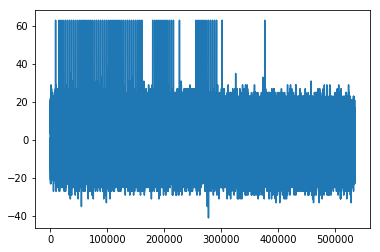

In [18]:
asm_corr = scipy.signal.correlate(2*bits-1, 2*asm_diff.astype('float')-1)
plt.plot(asm_corr);

Note that all the ASMs have correlated without any bit errors.

In [19]:
asm_corr[asm_corr > 40]

array([ 63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,
        63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,
        63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,
        63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,
        63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,
        63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,
        63.])

We have found a total of 130 ASMs. Of these, 117 mark SSDV packets, 5 are telemetry packets transmitted before the SSDV transmission, and the remaining 8 are telemetry packets interleaved with the SSDV transmission.

In [20]:
asm_corr[asm_corr > 40].size

67

We now look at the distances between the ASMs. DSLWP-B uses Turbo codewords of 3576 symbols. Since the ASM is 64 bits long and Turbo codewords are transmitted back-to-back, without any gap between them, we expect a distance of 3640 bits. 

Note that before we have stated that the ASM is 63 bits long. This is because the GMSK precoder is differential, so the first bit of the ASM is not defined, as it depends on the preceding data. Thus, we only use the 63 bits of the ASM that are fixed when doing the correlation.

Below we show the distances between the ASMs.

In [21]:
np.diff(np.where(asm_corr > 40)[0])

array([ 6164,  3640,  3640,  3640,  3640,  3640,  3640,  3640,  3640,
        3640,  3640,  3640,  3640,  3640,  3640,  3640,  3640,  3640,
        3640,  3640,  3640,  3640,  3640,  3640,  3640,  3640,  3640,
        3640,  3640,  3640,  3640,  3640,  3640,  3640,  3640,  3640,
        3640,  3640,  3640,  3640,  3640, 18995,  3640,  3640,  3640,
        3640,  3640,  3640,  3640,  3640,  3640,  3640, 10599, 28835,
        3640,  3640,  3640,  3640,  3640,  3640,  3640,  3640,  3640,
        3640,  9875, 74875])

We see that there are no problems with Turbo words being cut short.

Now we turn to the investigation of the frequency jump that happened about bit 20000.

First we extract the relevant piece of the signal.

In [22]:
start,end = 18000, 30000
xx = np.fromfile('/home/daniel/Descargas/DSLWP-B_PI9CAM_2018-08-12T08_32_25_436.4MHz_40ksps_complex.raw', dtype='complex64')[start*160:end*160]
xx = xx * np.exp(-1j*2*np.pi*np.arange(xx.size)*f/fs).astype('complex64')
xx = scipy.signal.lfilter(h, 1, xx).astype('complex64')

Now we plot the phase of the signal. The change in slope shows the frequency jump.

/usr/lib64/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


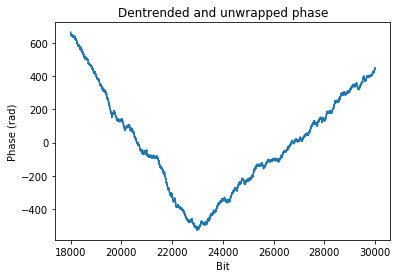

In [23]:
plt.plot(np.arange(start, end, 1/160), scipy.signal.detrend(np.unwrap(np.angle(xx))))
plt.title('Dentrended and unwrapped phase')
plt.ylabel('Phase (rad)')
plt.xlabel('Bit');